## Importing relevant packages

In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import SpatialDropout1D
from keras.preprocessing import text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
from keras.utils import pad_sequences
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import nltk
nltk.download('stopwords')
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D


[nltk_data] Downloading package stopwords to C:\Users\Loh Dai
[nltk_data]     Jiu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.) Importing dataframe and removing duplicates claims

In [3]:
df = pd.read_csv("politifact_data_labels.csv")
print(df.shape)
df.drop_duplicates(subset = ['claim'], keep = 'last', inplace = True)


(25923, 13)


## 2.) Apply text preprocessing (Removal of stopwords, lower casing)

In [4]:
df['claim'] = df['claim'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x)).apply(lambda x: x.replace("“", "")).apply(lambda x: x.replace("”", ""))

#Remove stopwords
stop = set(stopwords.words("english"))
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)
df['claim'] = df['claim'].apply(lambda x: remove_stopwords(x))
df['claim']

0              ron johnson came favor federal abortion ban
2           blake masters wants pass national ban abortion
3        brian kemp wants investigate punish women misc...
5        overturning roe v wade unconstitutional action...
6        way shape form access contraception limited ri...
                               ...                        
25918    100 days since passage economic stimulus saved...
25919    employee free choice act mandates elimination ...
25920    state senator illinois obama made sure women g...
25921    illinois senate barack obama passed legislatio...
25922    hillary clinton willing workers wages garnishe...
Name: claim, Length: 16733, dtype: object

## 3.) Train test split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df['claim'], df['accuracy'], random_state = 42, test_size = 0.2)

In [151]:
x_train.shape

(13386,)

In [152]:
def score_model(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

## 4.) Text feature engineering using TF-IDF vectorizer

In [153]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(x_train)
x_train_tfv =  tfv.transform(x_train) 
x_test_tfv = tfv.transform(x_test)

## 5.) Logistic Regression including hyperparameter tuning

In [154]:
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
}
lr = LogisticRegression(max_iter=10000, solver='liblinear')
lr_clf = GridSearchCV(lr,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
lr_clf.fit(x_train_tfv, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

              precision    recall  f1-score   support

           0       0.74      0.93      0.83      2399
           1       0.51      0.17      0.26       948

    accuracy                           0.72      3347
   macro avg       0.62      0.55      0.54      3347
weighted avg       0.67      0.72      0.66      3347



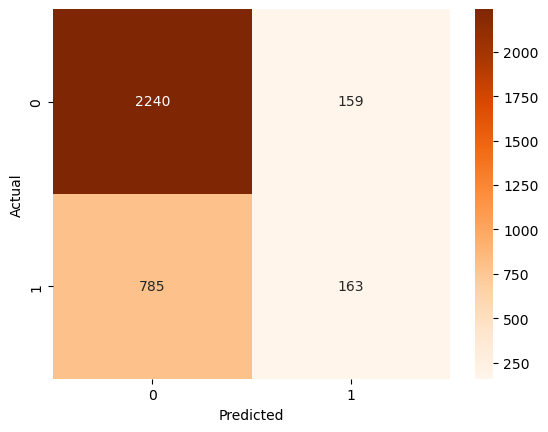

In [155]:
score_model(lr_clf, x_test_tfv, y_test)

In [156]:
print("Best combination of hyperparams:\n", lr_clf.best_params_, "\n")
print("Best mean_test_score score:\n", lr_clf.best_score_, "\n")

Best combination of hyperparams:
 {'C': 1.0, 'penalty': 'l2'} 

Best mean_test_score score:
 0.7221711314357926 



## 6.) Naive Bayes model

              precision    recall  f1-score   support

           0       0.73      0.97      0.84      2399
           1       0.59      0.11      0.18       948

    accuracy                           0.73      3347
   macro avg       0.66      0.54      0.51      3347
weighted avg       0.69      0.73      0.65      3347



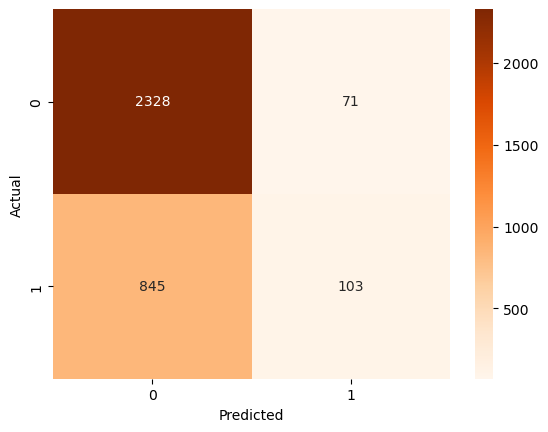

In [157]:
nb_clf = MultinomialNB()
nb_clf.fit(x_train_tfv, y_train)
score_model(nb_clf, x_test_tfv, y_test)

## 7.) Support Vector Classifier with hyperparameter tuning

              precision    recall  f1-score   support

           0       0.73      0.97      0.83      2399
           1       0.58      0.12      0.19       948

    accuracy                           0.73      3347
   macro avg       0.66      0.54      0.51      3347
weighted avg       0.69      0.73      0.65      3347



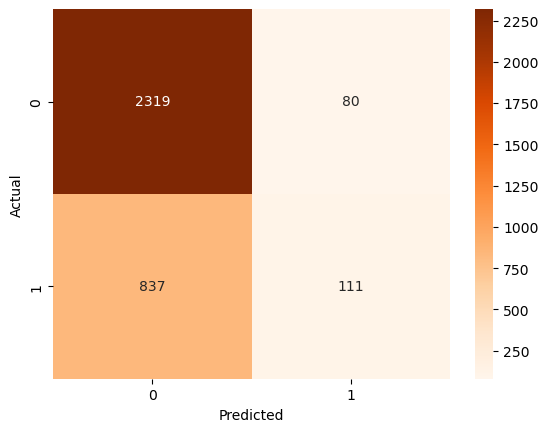

In [158]:
svc_clf = SVC()
svc_clf.fit(x_train_tfv, y_train)
score_model(svc_clf, x_test_tfv, y_test)

In [159]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'sigmoid']}

gd=GridSearchCV(estimator=SVC(),param_grid=param_grid,verbose=True)

gd.fit(x_train_tfv, y_train)

print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
0.7209772735578686
SVC(C=1, gamma=1)


              precision    recall  f1-score   support

           0       0.73      0.97      0.83      2399
           1       0.58      0.12      0.19       948

    accuracy                           0.73      3347
   macro avg       0.66      0.54      0.51      3347
weighted avg       0.69      0.73      0.65      3347



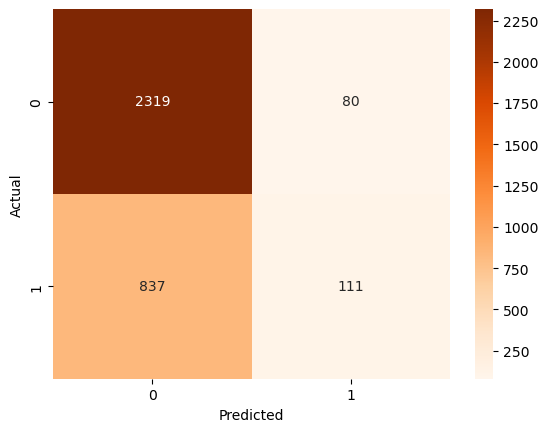

In [160]:
score_model(gd, x_test_tfv, y_test)


## 8.) XG Boost Classifier

[19:05:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.74      0.95      0.83      2399
           1       0.54      0.16      0.24       948

    accuracy                           0.72      3347
   macro avg       0.64      0.55      0.54      3347
weighted avg       0.68      0.72      0.66      3347



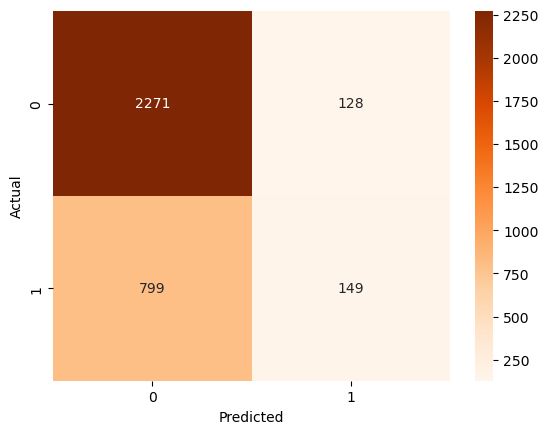

In [161]:
xg_clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, use_label_encoder=False)
xg_clf.fit(x_train_tfv, y_train)
score_model(xg_clf, x_test_tfv, y_test)

## 9.) Random Forest Classifier

In [162]:
rf = RandomForestClassifier(random_state=42)
grid_rf = {
    "max_depth": [5, 50, 75, 100],
    'min_samples_split': [12, 16, 20],
    'criterion': ['gini', 'entropy']
}
rf_grid = GridSearchCV(estimator = rf,      # model
                   param_grid = grid_rf,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
rf_grid.fit(x_train_tfv, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 50, 75, 100],
                         'min_samples_split': [12, 16, 20]},
             scoring='accuracy')

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      2399
           1       0.62      0.05      0.10       948

    accuracy                           0.72      3347
   macro avg       0.67      0.52      0.47      3347
weighted avg       0.69      0.72      0.63      3347



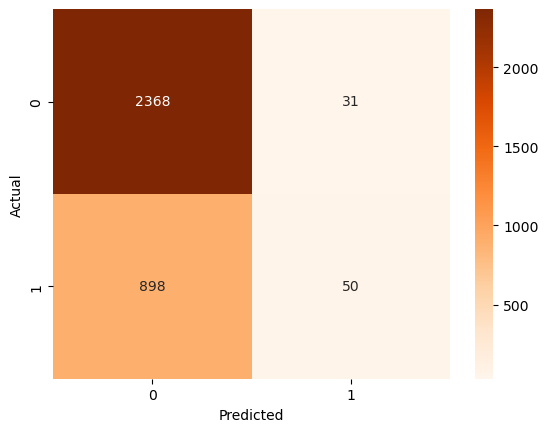

In [163]:
score_model(rf_grid, x_test_tfv, y_test)

## 10.) Deep Learning

Simple implementation of deep neural net

In [164]:
dnn_model = Sequential()

dnn_model.add(Dense(64, input_dim=11296, activation='relu'))
dnn_model.add(Dropout(0.2))

dnn_model.add(Dense(64, activation='relu'))
dnn_model.add(Dropout(0.3))

dnn_model.add(Dense(1))
dnn_model.add(Activation('sigmoid'))

# compile the model
dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])

In [165]:
dnn_model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 64)                723008    
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_61 (Dense)            (None, 64)                4160      
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_62 (Dense)            (None, 1)                 65        
                                                                 
 activation_26 (Activation)  (None, 1)                 0         
                                                                 
Total params: 727,233
Trainable params: 727,233
Non-t

In [166]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
dnn = dnn_model.fit(x_train_tfv.toarray(), y=y_train, batch_size=512, epochs=100, verbose=1, validation_data=(x_test_tfv.toarray(), y_test), callbacks=[earlystop])

Epoch 1/100
27/27 [==============================] - 3s 57ms/step - loss: 0.6441 - accuracy: 0.7110 - val_loss: 0.5877 - val_accuracy: 0.7168
Epoch 2/100
27/27 [==============================] - 1s 42ms/step - loss: 0.5609 - accuracy: 0.7152 - val_loss: 0.5610 - val_accuracy: 0.7168
Epoch 3/100
27/27 [==============================] - 1s 30ms/step - loss: 0.5034 - accuracy: 0.7152 - val_loss: 0.5471 - val_accuracy: 0.7168
Epoch 4/100
27/27 [==============================] - 1s 28ms/step - loss: 0.4428 - accuracy: 0.7559 - val_loss: 0.5596 - val_accuracy: 0.7221
Epoch 5/100
27/27 [==============================] - 1s 32ms/step - loss: 0.3730 - accuracy: 0.8403 - val_loss: 0.6049 - val_accuracy: 0.7006
Epoch 6/100
27/27 [==============================] - 1s 29ms/step - loss: 0.3016 - accuracy: 0.8855 - val_loss: 0.6856 - val_accuracy: 0.6917


## 11.) Word tokenizer and GloVe for word embedding

In [6]:
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(x_train)
x_train_seq = token.texts_to_sequences(x_train)
x_test_seq = token.texts_to_sequences(x_test)

# zero pad the sequences
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

word_index = token.word_index

In [7]:
embeddings_index = {}
f = open('glove.840B.300d.txt', encoding ="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
    embeddings_index[word] = coefs
f.close()

2196017it [03:27, 10583.52it/s]


In [8]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 16571/16571 [00:00<00:00, 376926.89it/s]


## 12.) LSTM Model

In [9]:
lstm_model = Sequential()
lstm_model.add(tf.keras.layers.Embedding(16572,
                    300,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))
lstm_model.add(SpatialDropout1D(0.3))
lstm_model.add(tf.keras.layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences = True, activation='tanh'))
lstm_model.add(Dense(300))

lstm_model.add(Dense(1))
lstm_model.add(Activation('sigmoid'))
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer='adam', metrics = ['accuracy'])

In [10]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 300)           4971600   
                                                                 
 spatial_dropout1d (SpatialD  (None, 70, 300)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 70, 64)            93440     
                                                                 
 dense (Dense)               (None, 70, 300)           19500     
                                                                 
 dense_1 (Dense)             (None, 70, 1)             301       
                                                                 
 activation (Activation)     (None, 70, 1)             0         
                                                        

In [11]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
lstm = lstm_model.fit(x_train_pad, y=y_train, batch_size=512, epochs=100, verbose=1, validation_data=(x_test_pad, y_test), callbacks=[earlystop])

Epoch 1/100
27/27 [==============================] - 23s 708ms/step - loss: 0.6273 - accuracy: 0.7118 - val_loss: 0.5952 - val_accuracy: 0.7160
Epoch 2/100
27/27 [==============================] - 18s 658ms/step - loss: 0.5957 - accuracy: 0.7153 - val_loss: 0.5953 - val_accuracy: 0.7168
Epoch 3/100
27/27 [==============================] - 18s 658ms/step - loss: 0.5946 - accuracy: 0.7153 - val_loss: 0.5925 - val_accuracy: 0.7169
Epoch 4/100
27/27 [==============================] - 18s 686ms/step - loss: 0.5937 - accuracy: 0.7155 - val_loss: 0.5920 - val_accuracy: 0.7171
Epoch 5/100
27/27 [==============================] - 18s 673ms/step - loss: 0.5932 - accuracy: 0.7156 - val_loss: 0.5915 - val_accuracy: 0.7171
Epoch 6/100
27/27 [==============================] - 20s 760ms/step - loss: 0.5927 - accuracy: 0.7156 - val_loss: 0.5913 - val_accuracy: 0.7170
Epoch 7/100
27/27 [==============================] - 39s 1s/step - loss: 0.5925 - accuracy: 0.7157 - val_loss: 0.5910 - val_accuracy: 0.

## 13.) GRU Model

In [173]:
gru_model = Sequential()
gru_model.add(tf.keras.layers.Embedding(16572,
                    300,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))
gru_model.add(SpatialDropout1D(0.3))
gru_model.add(tf.keras.layers.GRU(32, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
gru_model.add(Dense(10))

gru_model.add(Dense(1))
gru_model.add(Activation('sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
gru = gru_model.fit(x_train_pad, y=y_train, batch_size=512, epochs=100, 
          verbose=1, validation_data=(x_test_pad, y_test), callbacks=[earlystop])

Epoch 1/100
27/27 [==============================] - 29s 756ms/step - loss: 0.6449 - accuracy: 0.7085 - val_loss: 0.6007 - val_accuracy: 0.7162
Epoch 2/100
27/27 [==============================] - 20s 742ms/step - loss: 0.5988 - accuracy: 0.7136 - val_loss: 0.5941 - val_accuracy: 0.7170
Epoch 3/100
27/27 [==============================] - 20s 745ms/step - loss: 0.5963 - accuracy: 0.7150 - val_loss: 0.5933 - val_accuracy: 0.7168
Epoch 4/100
27/27 [==============================] - 21s 765ms/step - loss: 0.5952 - accuracy: 0.7149 - val_loss: 0.5934 - val_accuracy: 0.7170
Epoch 5/100
27/27 [==============================] - 20s 752ms/step - loss: 0.5945 - accuracy: 0.7153 - val_loss: 0.5925 - val_accuracy: 0.7169
Epoch 6/100
27/27 [==============================] - 20s 759ms/step - loss: 0.5944 - accuracy: 0.7151 - val_loss: 0.5924 - val_accuracy: 0.7170
Epoch 7/100
27/27 [==============================] - 20s 743ms/step - loss: 0.5940 - accuracy: 0.7153 - val_loss: 0.5924 - val_accuracy:

In [174]:
gru_model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x000001DB9B316BB0>>

## 14.) Convolution Neural Net

In [15]:
cnn_model = Sequential()
cnn_model.add(tf.keras.layers.Embedding(16572,
                    300,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))
cnn_model.add(Conv1D(32, 3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(300, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ["accuracy"])

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
cnn = cnn_model.fit(x_train_pad, y=y_train, batch_size=512, epochs=100, 
          verbose=1, validation_data=(x_test_pad, y_test), callbacks=[earlystop])  

Epoch 1/100
27/27 [==============================] - 3s 74ms/step - loss: 0.5881 - accuracy: 0.7079 - val_loss: 0.5708 - val_accuracy: 0.7165
Epoch 2/100
27/27 [==============================] - 2s 61ms/step - loss: 0.5458 - accuracy: 0.7226 - val_loss: 0.5558 - val_accuracy: 0.7177
Epoch 3/100
27/27 [==============================] - 2s 71ms/step - loss: 0.5197 - accuracy: 0.7388 - val_loss: 0.5535 - val_accuracy: 0.7177
Epoch 4/100
27/27 [==============================] - 2s 61ms/step - loss: 0.4870 - accuracy: 0.7576 - val_loss: 0.5640 - val_accuracy: 0.7033
Epoch 5/100
27/27 [==============================] - 2s 62ms/step - loss: 0.4449 - accuracy: 0.7860 - val_loss: 0.5838 - val_accuracy: 0.7084
Epoch 6/100
27/27 [==============================] - 2s 61ms/step - loss: 0.3999 - accuracy: 0.8110 - val_loss: 0.6220 - val_accuracy: 0.7096


## 15.) Stacking Classifier

In [178]:
estimators = [("Logistic Regression", lr_clf), ("Naive Bayes", nb_clf), ("Support Vector Classifier", svc_clf)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(x_train_tfv, y_train)

StackingClassifier(estimators=[('Logistic Regression',
                                GridSearchCV(cv=10,
                                             estimator=LogisticRegression(max_iter=10000,
                                                                          solver='liblinear'),
                                             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                                         'penalty': ['l1',
                                                                     'l2']},
                                             scoring='accuracy')),
                               ('Naive Bayes', MultinomialNB()),
                               ('Support Vector Classifier', SVC())],
                   final_estimator=LogisticRegression())

              precision    recall  f1-score   support

           0       0.75      0.93      0.83      2399
           1       0.52      0.20      0.29       948

    accuracy                           0.72      3347
   macro avg       0.64      0.56      0.56      3347
weighted avg       0.68      0.72      0.68      3347



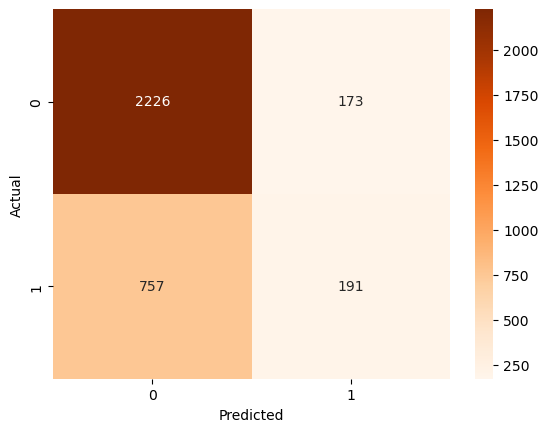

In [179]:
score_model(stacking_clf, x_test_tfv, y_test)